In [352]:
import numpy as np
import random
import json
from typing import Dict, List, Iterator, Literal, Union, Set, Optional
from __future__ import annotations
from pprint import pprint

np.set_printoptions(
    suppress=True,
    linewidth=180
)

In [353]:
class Logger:
    def __init__(self, name: str, level: Literal["debug","info","warn","error"] = "debug") -> None:
        self.name = name
        self.level = level
    def write(self, msg: str) -> None:
        print(f"[{self.name}] " + msg)
    def debug(self, msg: str) -> None:
        if not self.level == "debug": return
        self.write(msg)
    def info(self, msg: str) -> None:
        if self.level not in ["debug","info"]: return
        self.write(msg)
    def warn(self, msg: str) -> None:
        if self.level == "error": return
        self.write(msg)
    def error(self, msg: str) -> None:
        self.write(msg)

In [354]:
class Vulnerability:
    id: int
    attackerCost: int
    defenderCost: int
    attackerProb: float
    defenderProb: float
    severity: int
    def __init__(
        self,
        id: int,
        acost: Optional[int] = None,
        dcost: Optional[int] = None,
        aprob: Optional[float] = None,
        dprob: Optional[float] = None,
        sev: Optional[int] = None
    ) -> None:
        self.id = id
        if acost is None: acost = random.randint(1,5)
        if dcost is None: dcost = random.randint(1,5)
        if aprob is None: aprob = round(random.uniform(0.05,0.98),2)
        if dprob is None: dprob = round(random.uniform(0.8,0.98),2)
        if sev is None: sev = random.randint(1,5)
        self.attackerCost = acost
        self.defenderCost = dcost
        self.attackerProb = aprob
        self.defenderProb = dprob
        self.severity = sev
    def __str__(self) -> str:
        return f"Action(id={self.id}, acost={self.attackerCost}, dcost={self.defenderCost}, aprob={self.attackerProb}, dprob={self.defenderProb}, sev={self.severity})"
    def __repr__(self) -> str:
        return self.__str__()


In [355]:

class Vehicle:
    id: int
    risk: float
    severity_chances: Dict[int,float]
    in_platoon: bool
    dchoice: List[Vulnerability]
    achoice: List[Vulnerability]
    compromises: Set[Vulnerability]
    known_compromises: Set[Vulnerability]
    def __init__(
        self,
        id,
        risk: float,
        dchoice: List[Vulnerability],
        achoice: List[Vulnerability],
        sevs: Dict[int,float],
        in_platoon: bool = False
    ) -> None:
        self.id = id
        self.risk = risk
        self.dchoice = dchoice
        self.achoice = achoice
        self.severity_chances = sevs
        self.in_platoon = in_platoon
        self.compromises = set()
        self.known_compromises = set()
    def __str__(self) -> str:
        return f"Vehicle(risk={self.risk}, sevs={self.severity_chances}, in_platoon={self.in_platoon})"
    def __repr__(self) -> str:
        return self.__str__()


In [356]:
class VehicleProvider:
    def next(self) -> Vehicle:
        pass
    def reset(self) -> None:
        pass

class JsonVehicleProvider(VehicleProvider):
    vehicles: List[Vehicle]
    seen: Set[Vehicle]
    logger: Logger
    def __init__(self, logger: Logger, path: str) -> None:
        self.logger = logger
        self.seen = set()
        with open(path, "r") as f:
            loaded = json.load(f)
        self.logger.info(f"loaded {len(loaded)} vehicles")
        self.vehicles = []
        id = 0
        for v in loaded:
            self.vehicles.append(Vehicle(
                id,
                -1 * v["defender_util"],
                [Vulnerability(v["id"], v["attackerCost"], v["defenderCost"], v["attackerProb"], v["defenderProb"], v["severity"]) for v in v["dchoice"]],
                [Vulnerability(v["id"], v["attackerCost"], v["defenderCost"], v["attackerProb"], v["defenderProb"], v["severity"]) for v in v["achoice"]],
                {i:v["severity_chances"][str(i)] for i in range(1,6)}
            ))
            id += 1
    def next(self) -> Vehicle:
        candidates = [v for v in self.vehicles if v not in self.seen]
        if len(candidates) == 0: raise Exception("out of vehicles")
        rtn = random.choice(candidates)
        self.seen.add(rtn)
        return rtn

    def reset(self) -> None:
        self.logger.info("resetting json vehicle provider")
        self.i = 0


In [357]:
class Game:
    vehicles: List[Vehicle]
    vehicle_provider: lambda: Vehicle
    attacker_agent: "Agent"
    defender_agent: "Agent"
    logger: Logger
    turn: Literal["defender","attacker"]
    def __init__(self, logger: Logger, vehicle_provider: VehicleProvider, defender: "Agent", attacker: "Agent") -> None:
        self.vehicle_provider = vehicle_provider
        self.logger = logger
        self.defender_agent = defender
        self.attacker_agent = attacker
        self.reset()

    def reset(self) -> None:
        self.logger.info("resetting game")
        self.turn = "defender"
        self.vehicles = []
        for _ in range(12):
            self.vehicles.append(self.vehicle_provider.next())

    def step(self) -> None:
        self.turn = "defender" if self.turn == "attacker" else "attacker"
        if self.turn == "attacker":
            self.logger.debug(f"attacker turn begin")
            self.attacker_agent.take_turn(self)
        if self.turn == "defender":
            self.logger.debug(f"defender turn begin")
            self.defender_agent.take_turn(self)


In [358]:
class Agent:
    utility: int
    logger: Logger
    def __init__(self, logger: Logger) -> None:
        self.utility = 0
        self.logger = logger
    def take_turn(self, game: Game) -> None:
        pass
    
    def get_utility(self, game: Game) -> int:
        return None

In [359]:
# Very simple agent for defender
class BasicDefenderAgent(Agent):
    num_vehicles_monitoring_constraint: int
    monitoring: Vehicle
    recently_monitored: List[Vehicle]
    tolerance_threshold: int
    max_history: int
    max_size: int
    def __init__(self, logger: Logger) -> None:
        super().__init__(logger)
        self.recently_monitored = []
        self.monitoring = None
        self.utility = 0
        self.tolerance_threshold = 3
        self.max_history = 3
        self.max_size = 10
    
    def get_utility(self, game: Game) -> None:
        members = len([v for v in game.vehicles if v.in_platoon])
        compromises = -sum([s.severity for v in game.vehicles for s in v.compromises ])
        return members + compromises
    
    def take_turn(self, game: Game) -> None:
        if game.turn != "defender": self.logger.warn("sanity check failed, defender taking turn when game says not their turn")

        # finish monitoring vehicle
        m = self.monitoring
        if m is not None and m.in_platoon:
            # The current compromises become known
            for c in m.compromises:
                if c in m.known_compromises: continue
                self.logger.info(f"discovered compromise on vehicle {m.id} vuln {c.id} sev {c.severity}")
                m.known_compromises.add(c)
            # If beyond threshold, kicked from platoon
            total = sum([s.severity for s in m.known_compromises])
            if total > self.tolerance_threshold:
                self.logger.info(f"kicking vehicle {m.id} out of platoon, severity {total} exceeded threshold {self.tolerance_threshold}")
                m.in_platoon = False

        # pick next vehicle to monitor
        choices = [
            v for v in game.vehicles
            if v not in self.recently_monitored
        ]
        if len(choices) == 0: self.logger.warn("no candidates found to monitor?")
        self.monitoring = random.choice(choices)
        self.logger.debug(f"now monitoring vehicle id {self.monitoring.id}")


        # avoid monitoring the last 3 vehicles again
        if len(self.recently_monitored) >= self.max_history:
            self.recently_monitored.pop(0)
        self.recently_monitored.append(m)

        # allow low risk vehicles into the platoon
        candidates = [
            v for v in game.vehicles
            if v.risk <= 10 \
            and sum([s.severity for s in v.known_compromises]) <= self.tolerance_threshold \
            and len([v for v in game.vehicles if v.in_platoon]) < self.max_size
        ]

        # take while there's room in the platoon
        random.shuffle(candidates)
        while len([v for v in game.vehicles if v.in_platoon]) < self.max_size and len(candidates) > 0:
            candidates.pop().in_platoon = True
        
        # calculate util change
        change = self.get_utility(game)
        self.utility += change
        self.logger.debug(f"utility {self.utility} ({change:+d})")


In [360]:
# Very simple agent for attacker
class BasicAttackerAgent(Agent):
    def get_utility(self, game: Game) -> None:
        util = 0
        for v in game.vehicles:
            for c in v.compromises:
                if v.in_platoon:
                    util += c.severity * 2
                else:
                    util += c.severity
        return util

    def take_turn(self, game: Game) -> None:
        if game.turn != "attacker": self.logger.warn("sanity check failed, attacker taking turn when game says not their turn")
        
        # Pick a vehicle to attack.
        # In this case, the vehicles being attacked are always in the platoon.
        # A better agent would attack ones outside as well, there's no rule against it.
        candidates = [v for v in game.vehicles if v.in_platoon]
        def sort(v: Vehicle) -> float:
            return [x.severity ** 2 * x.attackerProb * (1 if not x in v.dchoice else 1 - x.defenderProb) for x in v.achoice if x not in v.compromises]
        candidates = sorted(candidates, key=sort)
        if len(candidates) == 0:
            candidates = game.vehicles
        if len(candidates) == 0: self.logger.warn("sanity check failed, no vehicles to attack")

        # pick victim to attack
        # attack vulnerabilities according to solution of subgame (achoice, dchoice)
        victim = candidates.pop()
        self.logger.debug(f"attacking vehicle id {victim.id}")
        for vuln in victim.achoice:
            success = random.randint(1,1000) / 1000 > vuln.attackerProb
            if success and vuln in victim.dchoice:
                success = random.randint(1,1000) / 1000 > vuln.defenderProb
            if success:
                self.logger.info(f"successfully compromised vehicle {victim.id} vuln {vuln.id} sev {vuln.severity}")
                victim.compromises.add(vuln)
        
        # calculate util change
        change = self.get_utility(game)
        self.utility += change
        self.logger.debug(f"utility {self.utility} ({change:+d})")


In [361]:
log_level = "debug"
game = Game(
    Logger("Game", log_level),
    JsonVehicleProvider(Logger("JsonVehicleProvider", log_level), "../subgame/python/solutions.json"),
    BasicDefenderAgent(Logger("BasicDefenderAgent", log_level)),
    BasicAttackerAgent(Logger("BasicAttackerAgent", log_level))
)
dutils = []
autils = []
num_rounds = 100
for i in range(num_rounds):
    game.step()
    dutils.append(game.defender_agent.utility)
    autils.append(game.attacker_agent.utility)

[JsonVehicleProvider] loaded 1000 vehicles
[Game] resetting game
[Game] attacker turn begin
[BasicAttackerAgent] attacking vehicle id 966
[BasicAttackerAgent] successfully compromised vehicle 966 vuln 2 sev 4
[BasicAttackerAgent] successfully compromised vehicle 966 vuln 4 sev 4
[BasicAttackerAgent] successfully compromised vehicle 966 vuln 6 sev 1
[BasicAttackerAgent] utility 0 (+0)
[Game] defender turn begin
[BasicDefenderAgent] now monitoring vehicle id 521
[BasicDefenderAgent] utility 6 (+6)
[Game] attacker turn begin
[BasicAttackerAgent] attacking vehicle id 521
[BasicAttackerAgent] successfully compromised vehicle 521 vuln 4 sev 3
[BasicAttackerAgent] successfully compromised vehicle 521 vuln 6 sev 3
[BasicAttackerAgent] utility 12 (+12)
[Game] defender turn begin
[BasicDefenderAgent] discovered compromise on vehicle 521 vuln 6 sev 3
[BasicDefenderAgent] discovered compromise on vehicle 521 vuln 4 sev 3
[BasicDefenderAgent] kicking vehicle 521 out of platoon, severity 6 exceeded 

IndexError: list index out of range

In [ ]:
print(game.defender_agent.utility)
pprint(game.vehicles)

-2439
[Vehicle(risk=7.82, sevs={1: 0, 2: 0.87, 3: 0, 4: 0.18, 5: 0}, in_platoon=False),
 Vehicle(risk=25.56, sevs={1: 0.29, 2: 0, 3: 0, 4: 0.52, 5: 0.57}, in_platoon=False),
 Vehicle(risk=9.92, sevs={1: 0, 2: 0, 3: 0.6, 4: 0.25, 5: 0.02}, in_platoon=False),
 Vehicle(risk=6.38, sevs={1: 0.02, 2: 0, 3: 0, 4: 0.13, 5: 0.16}, in_platoon=False),
 Vehicle(risk=22.92, sevs={1: 0, 2: 0.6, 3: 0.69, 4: 0.73, 5: 0.11}, in_platoon=False)]


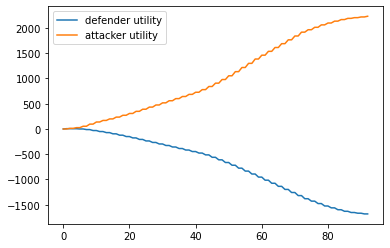

In [367]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()
x = list(range(0, num_rounds))
ax.plot(dutils, label="defender utility")
ax.plot(autils, label="attacker utility")
plt.legend()